# Exercise 5

Using Gaussian processes, fit an inhomogeneous conductivity for the Poisson equation,

\begin{matrix}
-\nabla \cdot k \nabla u = f & x \in (-1,1) \\
u = 0 & x \in  \left\{-1,1\right\}
\end{matrix}

provided a pair of functions $\{u,f\}$. Use a Legendre polynomial for $k$.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import tensorflow_probability as tfp
import sympy
import data

import importlib
importlib.reload(data)

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

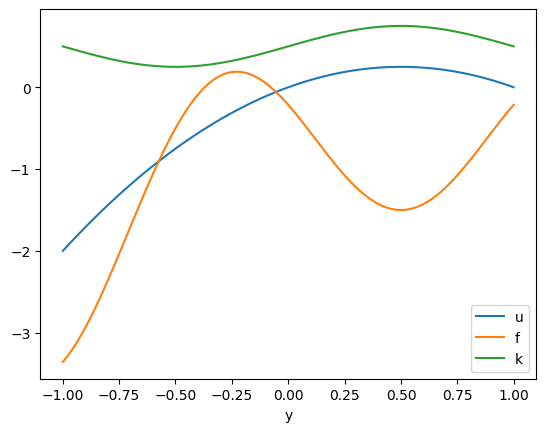

In [2]:
#Data and true conductivity

x_data,u_data,f_data,k_true = data.get_ex5()

plt.plot(x_data,u_data,label='u')
plt.plot(x_data,f_data,label='f')
plt.plot(x_data,k_true,label='k')
plt.xlabel('x')
plt.xlabel('y')
plt.legend()



In [3]:
order = 10

gp_params = sympy.symbols('a,l')
a,l=gp_params
c = sympy.IndexedBase('c')
params = gp_params+(c,)
x,xp,z = sympy.symbols('x,xp,z')




In [4]:
k_fit = sum([c[i]*sympy.polys.orthopolys.legendre_poly(i,x=z) for i in range(order+1)])

fk_fit = sympy.lambdify((x,)+params,k_fit.subs(z,x))

In [5]:
K    = a*sympy.exp(-l*(x-xp)**2*1)
Kxp  = sympy.diff(k_fit.subs(z,xp)*sympy.diff(K,xp),xp)
Kxxp = sympy.diff(k_fit.subs(z,x)*sympy.diff(Kxp,x),x)

fK = sympy.lambdify((x,xp)+params,K,modules='tensorflow')
fKxp = sympy.lambdify((x,xp)+params,Kxp,modules='tensorflow')
fKxxp = sympy.lambdify((x,xp)+params,Kxxp,modules='tensorflow')


In [6]:

with tf.device('/CPU:0'):

    aT = np.float64(.4)
    lT = np.float64(100.)
    cT = np.ones((order+1,))
    p = tf.Variable(tf.concat([[aT],[lT],cT],0))
    def splitparams(p):
        return tf.split(p,[1,1,order+1])
    I = 1e-5*tf.linalg.eye(u_data.shape[0]+f_data.shape[0],dtype=tf.float64)

    def loss(p):
        aT,lT,cT = splitparams(p)
        aT=tf.nn.relu(p[0])+1e-5
        lT=tf.nn.relu(p[1])+1e-5
        K11 = fK(x_data[:,None],x_data[None],aT,lT,cT)
        K12 = fKxp(x_data[:,None],x_data[None],aT,lT,cT)
        K22 = fKxxp(x_data[:,None],x_data[None],aT,lT,cT)
        K = tf.concat([tf.concat([K11,(K12)],axis=1),tf.concat([tf.transpose(K12),K22],axis=1)],axis=0)
        KI = K + I
        uf = tf.concat([u_data,f_data],axis=0)
        return tf.reduce_sum(uf*tf.linalg.solve(KI,uf[:,None])[:,0]) + tf.linalg.logdet(KI)


    opt = tf.keras.optimizers.legacy.Adam(1e-2)
    @tf.function
    def GD():
        with tf.GradientTape() as tape:
            tape.watch(p)
            loss_ = loss(p)
        grad = tape.gradient(loss_,p)
        opt.apply_gradients([(grad,p)])
        return loss_

    @tf.function
    def loss_grad(p):
        return tfp.math.value_and_gradient(loss,p)   

    for _ in range(3000):
        loss_=GD()
        print(loss_.numpy())


117766.82383357904
103430.75367173963
89909.87310565257
77452.15543055123
66398.10195765035
56999.704669932675
49662.143652079816
44933.09470302299
43158.581220545304
43553.93838052431
43994.98933576491
42731.02249544442
39597.950118459645
35581.76737382932
31786.001332692635
28834.559661716015
26810.22842236603
25456.266144659352
24409.610818967863
23358.345357733393
22110.745568956565
20604.222125662647
18885.09073400256
17076.974334352242
15343.595175319982
13844.829807397884
12685.98146885695
11871.228417267073
11290.71286809768
10771.44204067303
10175.700563142993
9475.305782574167
8748.160787509156
8113.644401860831
7661.617154030307
7415.276566636201
7334.674250158494
7345.724516893001
7374.966076379533
7375.450438630694
7336.573702864842
7277.369536449691
7228.093658477998
7208.67444516035
7214.074664002754
7214.285071193269
7169.548714989547
7052.16896927141
6861.628673541985
6624.45377674944
6380.705810453717
6166.5159405745835
6001.997260487442
5888.534976043957
5813.8762394

In [7]:
optim_results = tfp.optimizer.bfgs_minimize(
      loss_grad,
      initial_position=p,
      f_absolute_tolerance=1e-3)
print(optim_results.converged,optim_results.position)


tf.Tensor(True, shape=(), dtype=bool) tf.Tensor(
[ 1.40346469e-01  9.65511928e+01  4.95828632e-01  2.36912402e-01
  8.98916333e-03 -2.77981565e-01  3.13583409e-03  4.13025358e-02
 -1.47111946e-02 -9.41438998e-03  1.45580801e-02  1.63758850e-02
  1.25049244e-02], shape=(13,), dtype=float64)


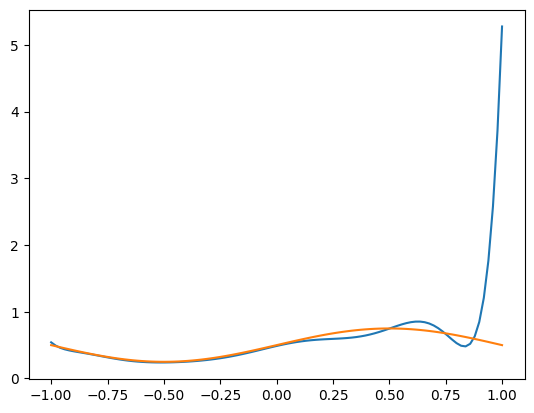

In [8]:
#fit for k after Adam optimization
plt.plot(x_data,fk_fit(x_data,*splitparams(p)))
plt.plot(x_data,k_true)

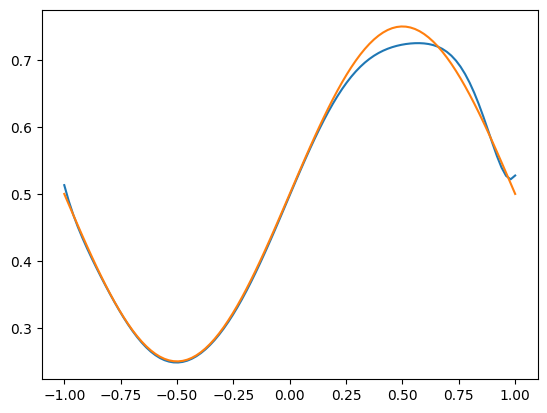

In [9]:
#fit for k after BFGS optimization
plt.plot(x_data,fk_fit(x_data,*splitparams(optim_results.position)))
plt.plot(x_data,k_true)